# Quenching Timescales

First we import all the necessary packages and set the paths to the simulations. 

In [1]:
import os # set tangos environment variable before loading tangos so we know where the data is
os.environ['TANGOS_DB_CONNECTION'] = '/home/akinshol/Data/Timescales/TangosData/h329.db'
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
import pynbody
import tangos
from bulk import *
    
%matplotlib inline
#mpl.rcParams['font.monospace'] = 'Terminal'
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [2]:

data = read_all()
data.keys()

Index(['B-V', 'B_mag', 'G_inflow_0', 'G_inflow_1.5', 'G_inflow_2.5',
       'G_outflow_0', 'G_outflow_1.5', 'G_outflow_2.5', 'Gout_T', 'HIgasfrac',
       'I_mag', 'M_gas', 'M_star', 'R_mag', 'Rmax', 'Rvir', 'SFR', 'U_mag',
       'V90_Vdisp', 'V_mag', 'Xc', 'Yc', 'Zc', 'a', 'age', 'c', 'c_a',
       'fMhires', 'feh', 'g_temp', 'gasfrac', 'h1dist', 'haloid', 'hostHalo',
       'id2', 'mHI', 'mass', 'n_gas', 'n_particles', 'n_star', 'ovdens',
       'sSFR', 'sfh', 'sfhbins', 'tquench', 'zgas', 'zstar', 'sim'],
      dtype='object')

In [6]:
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue,
                                          pynbody.halo.hop.HOPCatalogue]

## Quenching Time

First need to figure out the time of quenching. This is done in the bulk_processing routine, where `tquench` is defined as the lookback time at which the halo had formed 90% of its $z=0$ stellar mass. 

In [68]:
data = read_file('/home/akinshol/Data/DataFiles/h329','h329')
data = data[data.n_star>100]
tquench = np.array(data.tquench,dtype=float)
haloids = np.array(data.haloid,dtype=int)

tquench = tquench[haloids!=1]
haloids = haloids[haloids!=1]
mstar = data.M_star[data.haloid!=1]
    
for i, t, m in zip(haloids,tquench,mstar):
    print(f'Halo {i} (stellar mass {m:.2e}) quenched {t} Gyr ago')


Halo 119 (stellar mass 3.08e+06) quenched 10.387499955872318 Gyr ago
Halo 7 (stellar mass 2.75e+07) quenched 3.2793139118303394 Gyr ago
Halo 32 (stellar mass 1.49e+06) quenched 6.430988246630373 Gyr ago
Halo 116 (stellar mass 1.10e+06) quenched 10.243408374357623 Gyr ago
Halo 443 (stellar mass 6.11e+05) quenched 6.270410008673604 Gyr ago


## Infall Time

Now we need to determine infall time, which we do using the Tangos package. 

In [59]:
s = tangos.get_simulation('snapshots')

halo1 = s.timesteps[-1].halos[0]
h1x, h1y, h1z, h1r, h1t = halo1.calculate_for_progenitors('Xc','Yc','Zc','Rvir','t()')
h1r = np.array(h1r)
h1t = np.array(h1t)

In [63]:

tinfall = np.array([])
for i in haloids:
    # get halo i in final timestep
    halo = s.timesteps[-1].halos[i-1] 
    # calculate position back in time for major progenitors
    x, y, z, t = halo.calculate_for_progenitors('Xc','Yc','Zc','t()')

    t = np.array(t)
    minimum = np.min(t)-0.01
    maximum = np.max(t)+0.01
    matchTime = (h1t > minimum)&(h1t < maximum)

    nh1x = h1x[matchTime]
    nh1y = h1y[matchTime]
    nh1z = h1z[matchTime]
    nh1r = h1r[matchTime]
    
    # compute distance from halo 1 scaled to halo 1 virial radius
    distance = np.sqrt( (x-nh1x)**2 + (y-nh1y)**2 + (z-nh1z)**2 )  /  nh1r
    
    # lookback time to first infall, i.e. the minimum t at which the distance from halo 1 is < 1 virial radius
    age = 13.800797497330507
    try:
        t = age - np.min( t[distance < 1. ] )
        print(f'Halo {i} infell {t:.2f} Gyr ago')
    except ValueError as err:
        print(err)
        t = None
    tinfall = np.append(tinfall,t)

Halo 119 infell 5.19 Gyr ago
Halo 7 infell 0.54 Gyr ago
Halo 32 infell 5.39 Gyr ago
Halo 116 infell 8.94 Gyr ago
Halo 443 infell 2.80 Gyr ago


## Plot Quenching Time vs Infall Time

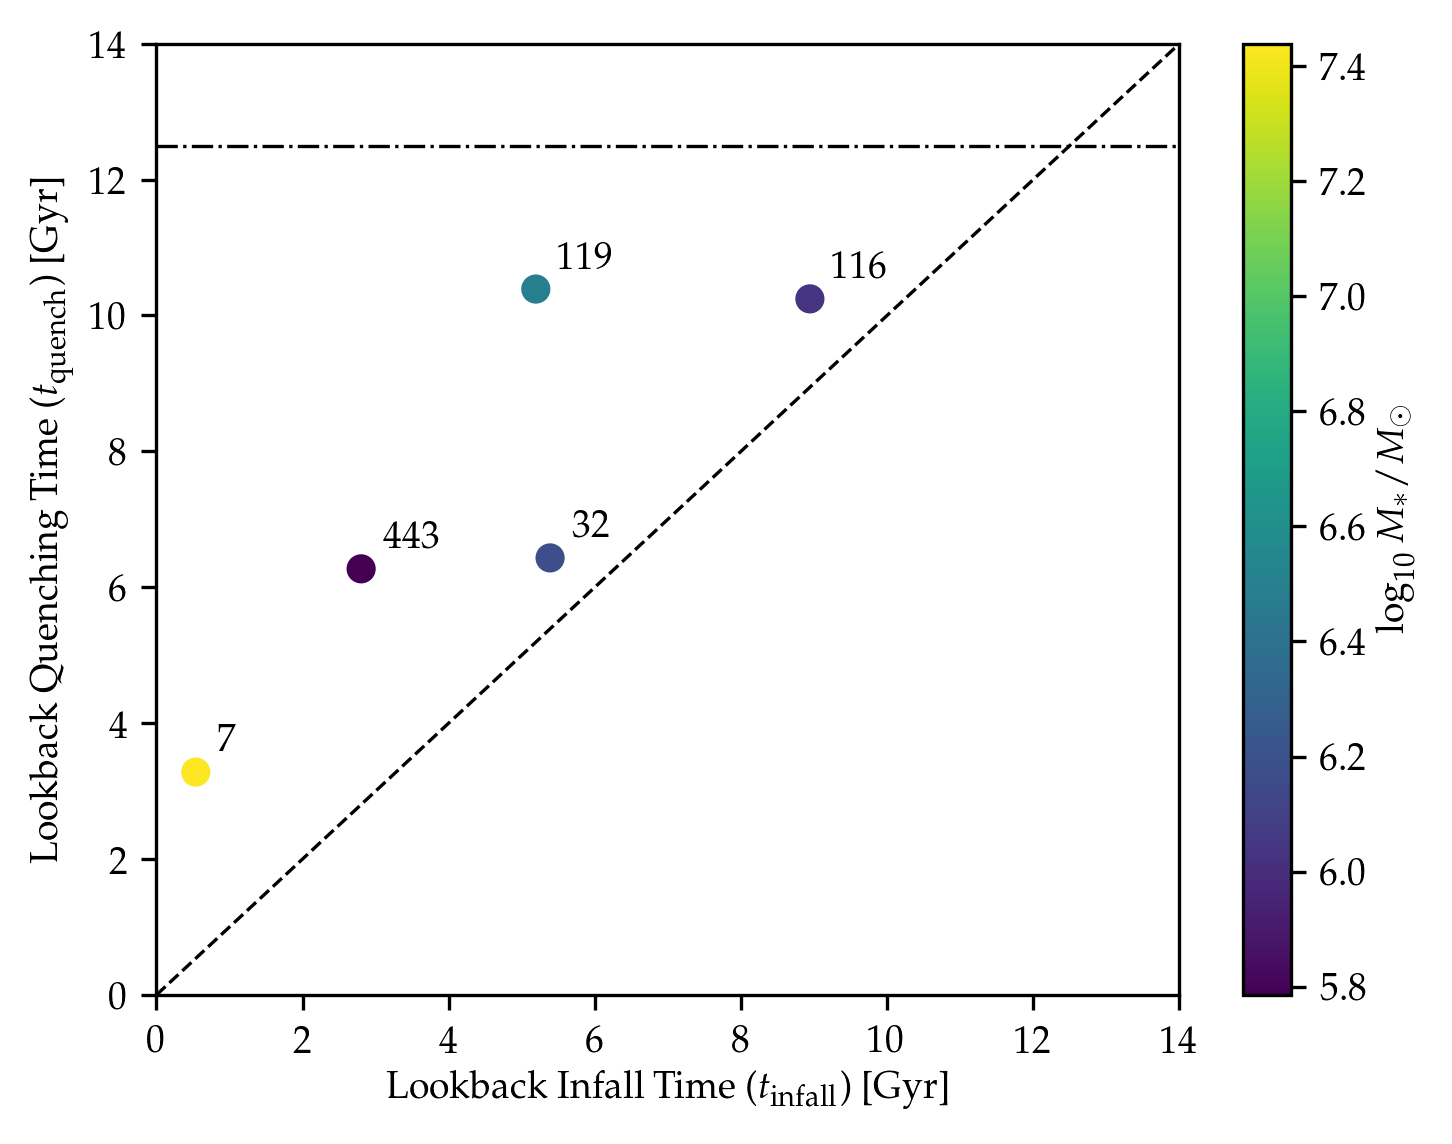

In [84]:
reiontime = 12.5

fig, ax = plt.subplots(1,1,figsize=(5.5,4.2),dpi=300)
im = ax.scatter(tinfall, tquench, c=np.log10(np.array(mstar,dtype=float)), marker='o', zorder=10)
cbar = fig.colorbar(im,ax=ax)
cbar.ax.set_ylabel(r'$\log_{10} M_* / M_{\odot}$')
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0)
ax.plot([0,20], [reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
for i, txt in enumerate(haloids):
    ax.annotate(txt, (tinfall[i]+0.3, tquench[i]+0.3))
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

plt.show()